In [1]:
from mitoolspro.plotting import PlotComposer, ScatterPlotter, AxesComposer
import pandas as pd
import numpy as np
from mitoolspro.pandas import idxslice
import matplotlib.pyplot as plt

# Plots and Axes Composers Examples

This notebook contains examples of how to use the `PlotComposer` and `AxesComposer` classes to create plots and axes composers, portraying their functionality and flexibility.

## Artifical Data

#### Functions to Generate Countries Indicators

In [2]:
def generate_gdp(year_idx: int, base_gdp: float, growth_rate: float) -> float:
    gdp = base_gdp * ((1.0 + growth_rate) ** year_idx)
    noise = np.random.normal(loc=0.0, scale=0.05)  # ±5% relative noise
    return gdp * (1 + noise)

def generate_population(year_idx: int, start_pop: float, end_pop: float, total_years: int) -> float:
    fraction = year_idx / (total_years - 1)
    pop = start_pop + (end_pop - start_pop) * fraction
    noise_factor = 0.03 * pop
    pop += np.random.normal(loc=0.0, scale=noise_factor)
    return max(pop, 0)  # population can't be negative

def generate_unemployment(year_idx: int) -> float:
    base = 0.1 + 0.1 * np.sin(2 * np.pi * (year_idx / 10.0))  # 10-year cycles
    noise = np.random.normal(loc=0.0, scale=0.03)
    val = np.clip(base + noise, 0, 0.25)
    return val * 100

def generate_happiness(year_idx: int, previous_val: float) -> float:
    step = np.random.normal(loc=0.0, scale=0.3)
    new_val = previous_val + step
    new_val = np.clip(new_val, 0, 10)
    return new_val

def generate_co2(year_idx: int, base_co2: float, growth_rate: float) -> float:
    co2_val = base_co2 * ((1.0 + growth_rate) ** year_idx)
    noise = np.random.normal(loc=0.0, scale=0.05)
    return co2_val * (1 + noise)

#### Initialize Country Data

In [3]:
np.random.seed(42)
years = range(1900, 2021)
n_years = len(years)
n_indicators = 5
continents = {
    "Africa":    ["Algeria", "Nigeria", "Kenya", "Egypt", "South Africa"],
    "Asia":      ["China", "India", "Japan", "South Korea", "Indonesia"],
    "Europe":    ["Germany", "France", "Italy", "Spain", "Poland"],
    "Americas":  ["USA", "Canada", "Brazil", "Argentina", "Mexico"],
    "Oceania":   ["Australia", "New Zealand", "Fiji", "Papua New Guinea", "Samoa"]
}
country_continent_pairs = []
for cont, countries in continents.items():
    for c in countries:
        country_continent_pairs.append((c, cont))
country_params = {}
for c, cont in country_continent_pairs:
    base_gdp = np.random.uniform(1e3, 1e4)
    gdp_growth = np.random.uniform(0.02, 0.08)
    start_pop = np.random.uniform(1e5, 5e6)
    end_pop = np.random.uniform(5e6, 2e8)
    base_co2 = np.random.uniform(1, 500)
    co2_growth = np.random.uniform(0.01, 0.05)
    country_params[c] = {
        "continent": cont,
        "base_gdp": base_gdp,
        "gdp_growth": gdp_growth,
        "start_pop": start_pop,
        "end_pop": end_pop,
        "base_co2": base_co2,
        "co2_growth": co2_growth
    }
all_rows = []
for c, cont in country_continent_pairs:
    params = country_params[c]
    current_happiness = np.random.uniform(0, 10)
    for i, y in enumerate(years):
        gdp_val = generate_gdp(
            year_idx=i, 
            base_gdp=params["base_gdp"], 
            growth_rate=params["gdp_growth"]
        )
        pop_val = generate_population(
            year_idx=i,
            start_pop=params["start_pop"],
            end_pop=params["end_pop"],
            total_years=n_years
        )
        unemp_val = generate_unemployment(i)
        current_happiness = generate_happiness(i, current_happiness)
        co2_val = generate_co2(
            year_idx=i,
            base_co2=params["base_co2"],
            growth_rate=params["co2_growth"]
        )
        row = {
            "Country": c,
            "Continent": cont,
            "Year": y,
            "GDP": gdp_val,
            "Population": pop_val,
            "UnemploymentRate": unemp_val,
            "HappinessIndex": current_happiness,
            "CO2": co2_val
        }
        all_rows.append(row)
countries_data = pd.DataFrame(all_rows).set_index(["Year", "Continent", "Country"])
countries_data

GDP    Population  UnemploymentRate  \
Year Continent Country                                                 
1900 Africa    Algeria   4245.262365  3.640151e+06         11.019463   
1901 Africa    Algeria   4436.966253  4.561897e+06         18.197275   
1902 Africa    Algeria   5426.532085  5.890476e+06         16.868643   
1903 Africa    Algeria   5712.987754  6.977918e+06         22.131333   
1904 Africa    Algeria   6072.531785  7.342209e+06         17.486861   
...                              ...           ...               ...   
2016 Oceania   Samoa    46627.759549  1.002280e+08          3.363125   
2017 Oceania   Samoa    41517.330587  9.959914e+07          4.956270   
2018 Oceania   Samoa    44817.406713  1.022178e+08          0.000000   
2019 Oceania   Samoa    48383.666494  9.794200e+07          4.416236   
2020 Oceania   Samoa    47281.749546  1.093456e+08         13.637153   

                        HappinessIndex         CO2  
Year Continent Country                              
1900 Africa    Algeria        9.080445   81.878496  
1901 Africa    Algeria        8.839896   85.679188  
1902 Africa    Algeria        8.862965   79.426079  
1903 Africa    Algeria        8.865708   81.245149  
1904 Africa    Algeria        8.591301   86.711133  
...                                ...         ...  
2016 Oceania   Samoa          2.725775  275.993564  
2017 Oceania   Samoa          2.736847  324.501184  
2018 Oceania   Samoa          2.514163  326.999645  
2019 Oceania   Samoa          2.299312  298.680486  
2020 Oceania   Samoa          1.694951  325.640411  

[3025 rows x 5 columns]

## General Definitions

In [4]:
continents = countries_data.index.get_level_values("Continent").unique()
continents_col = "Continent"
years = countries_data.index.get_level_values("Year").unique()
indicators = [c for c in countries_data.columns if c != "GDP"]

In [5]:
y_var = "GDP"
x_var = "Population"

In [6]:
edgecolors = {
    "Population": "grey",
    "GDP": "green",
    "UnemploymentRate": "orange",
    "HappinessIndex": "brown",
    "CO2": "red",
}
facecolors = {
    "Africa": "white",
    "Asia": "darkgrey",
    "Europe": "lightgrey",
    "Americas": "black",
    "Oceania": "lightcyan",
}

## PlotComposer with multiple ScatterPlotters

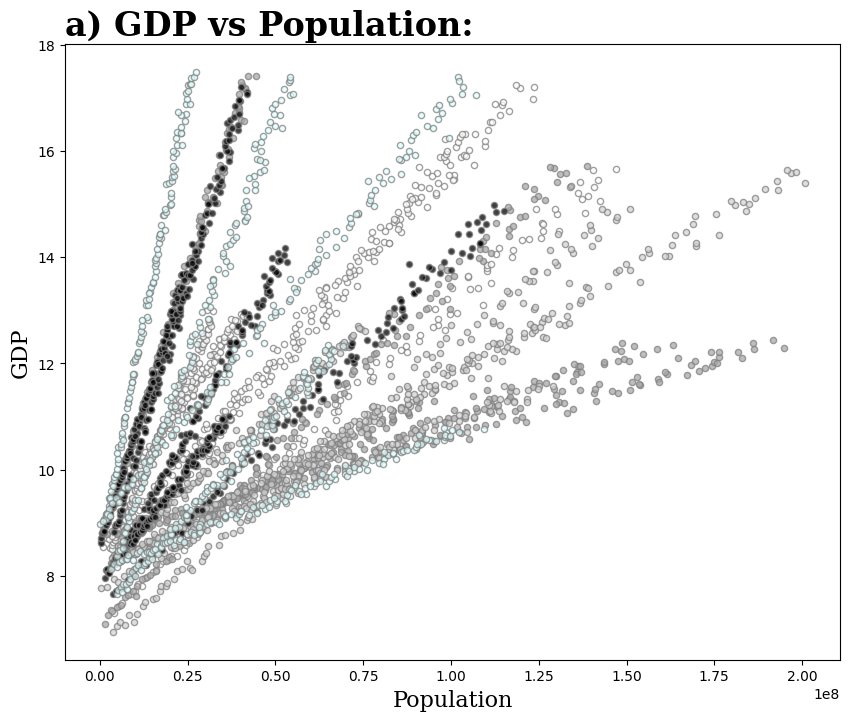

In [7]:
plot = PlotComposer()
for continent in continents:
    continent_idxslice = idxslice(countries_data, level=continents_col, values=continent, axis=0)
    plot.add_plotter(
        ScatterPlotter(
            x_data=countries_data.loc[continent_idxslice, x_var].values,
            y_data=np.log(countries_data.loc[continent_idxslice, y_var].values),
        )
        .set_edgecolor(edgecolors[x_var])
        .set_facecolor(facecolors[continent])
        .set_marker("o")
        .set_size(20)
        .set_alpha(0.75)
    )
plot.set_title(f"a) {y_var} vs {x_var}:", fontsize=24, fontweight="bold", loc="left", fontfamily="serif")
plot.set_xlabel(f"{x_var}", fontsize=16, fontfamily="serif")
plot.set_ylabel(f"{y_var}", fontsize=16, fontfamily="serif")
ax = plot.draw()

## Store Created PlotComposer

In [8]:
plot.save_composer(".plot_params/composed_plot.json")

## Load and Draw Created PlotComposer

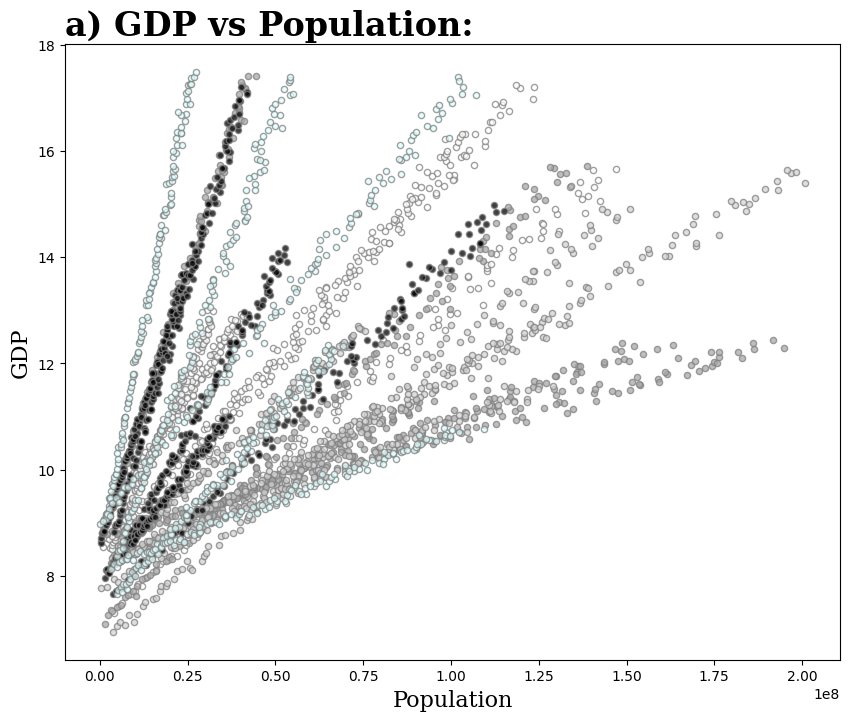

In [9]:
plot = PlotComposer.from_json(".plot_params/composed_plot.json")
ax = plot.draw()

## Generate Multiple PlotComposers Independently

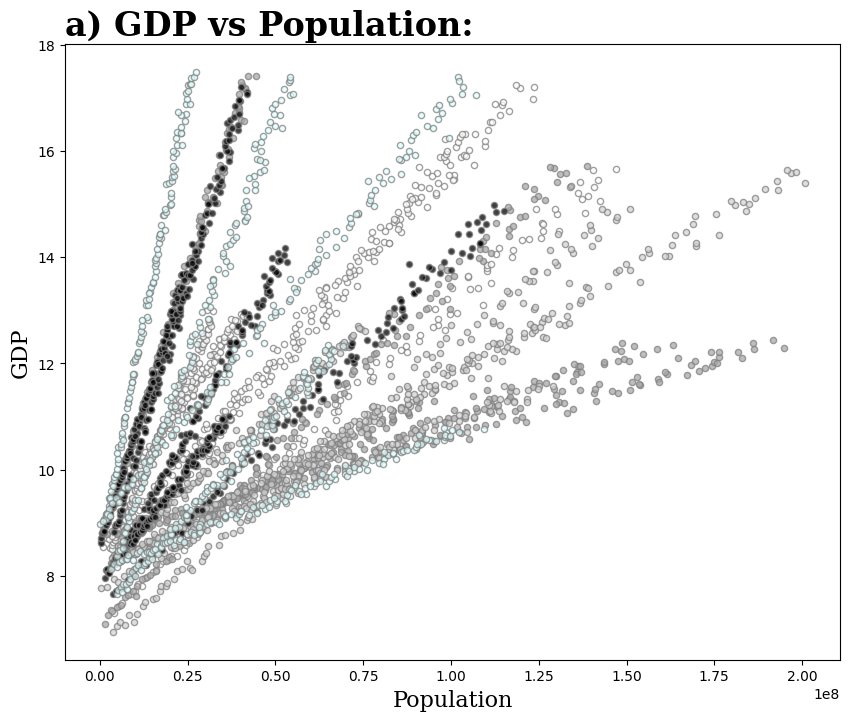

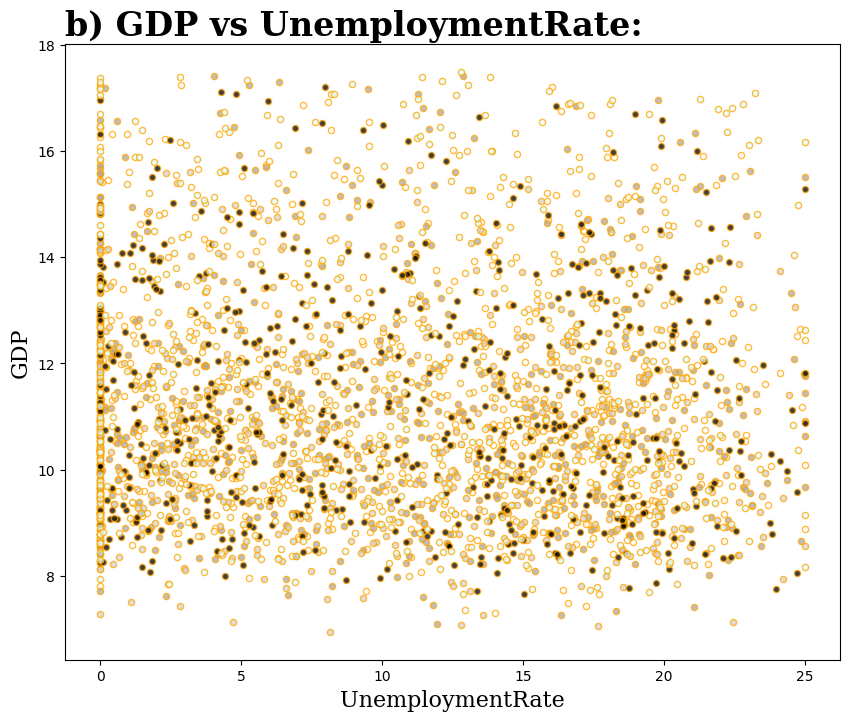

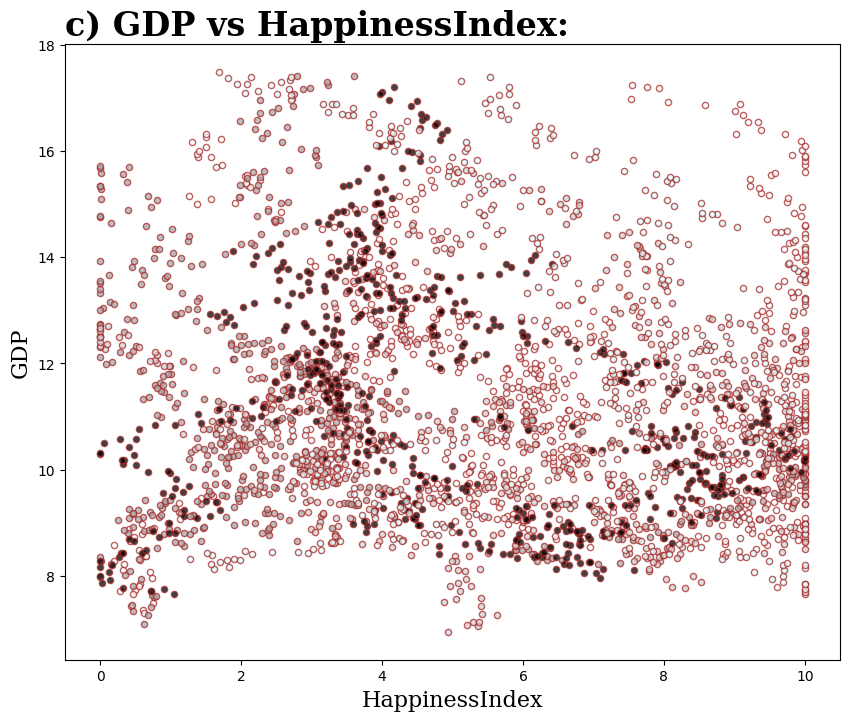

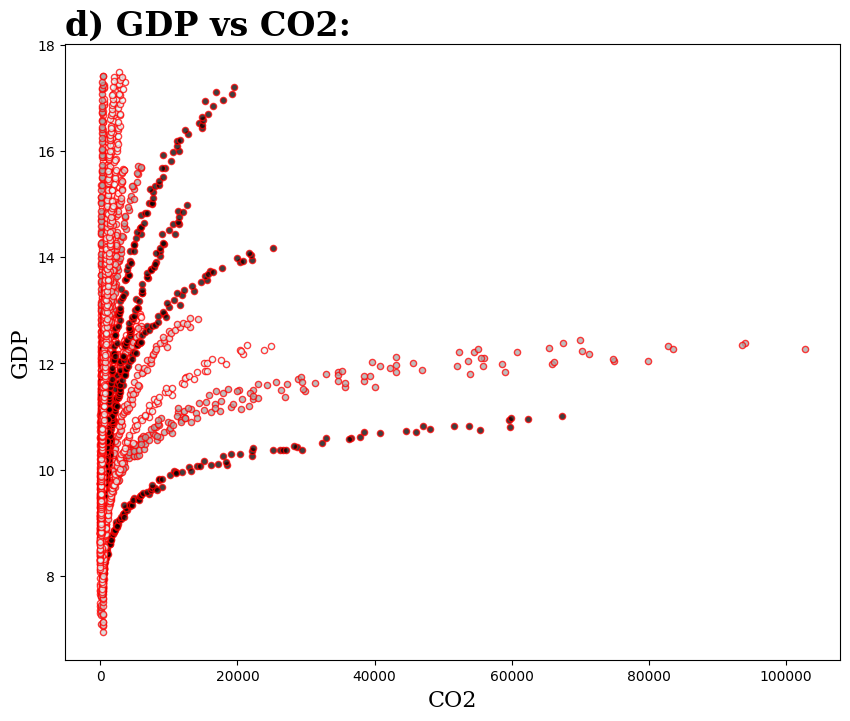

In [10]:
plots = []
for n, var in enumerate(indicators):
    plot = PlotComposer()
    for continent in continents:
        continent_idxslice = idxslice(countries_data, level=continents_col, values=continent, axis=0)
        plot.add_plotter(
            ScatterPlotter(
                x_data=countries_data.loc[continent_idxslice, var].values,
                y_data=np.log(countries_data.loc[continent_idxslice, y_var].values),
            )
            .set_edgecolor(edgecolors[var])
            .set_facecolor(facecolors[continent])
            .set_marker("o")
            .set_size(20)
            .set_alpha(0.75)
        )
    plot.set_title(f"{'abcd'[n]}) {y_var} vs {var}:", fontsize=24, fontweight="bold", loc="left", fontfamily="serif")
    plot.set_xlabel(f"{var}", fontsize=16, fontfamily="serif")
    plot.set_ylabel(f"{y_var}", fontsize=16, fontfamily="serif")
    plots.append(plot)
    plot.save_composer(".plot_params/composed_plot.json")
    plot = PlotComposer.from_json(".plot_params/composed_plot.json")
    plot.draw()

## Relate Multiple PlotComposers with an AxesComposer

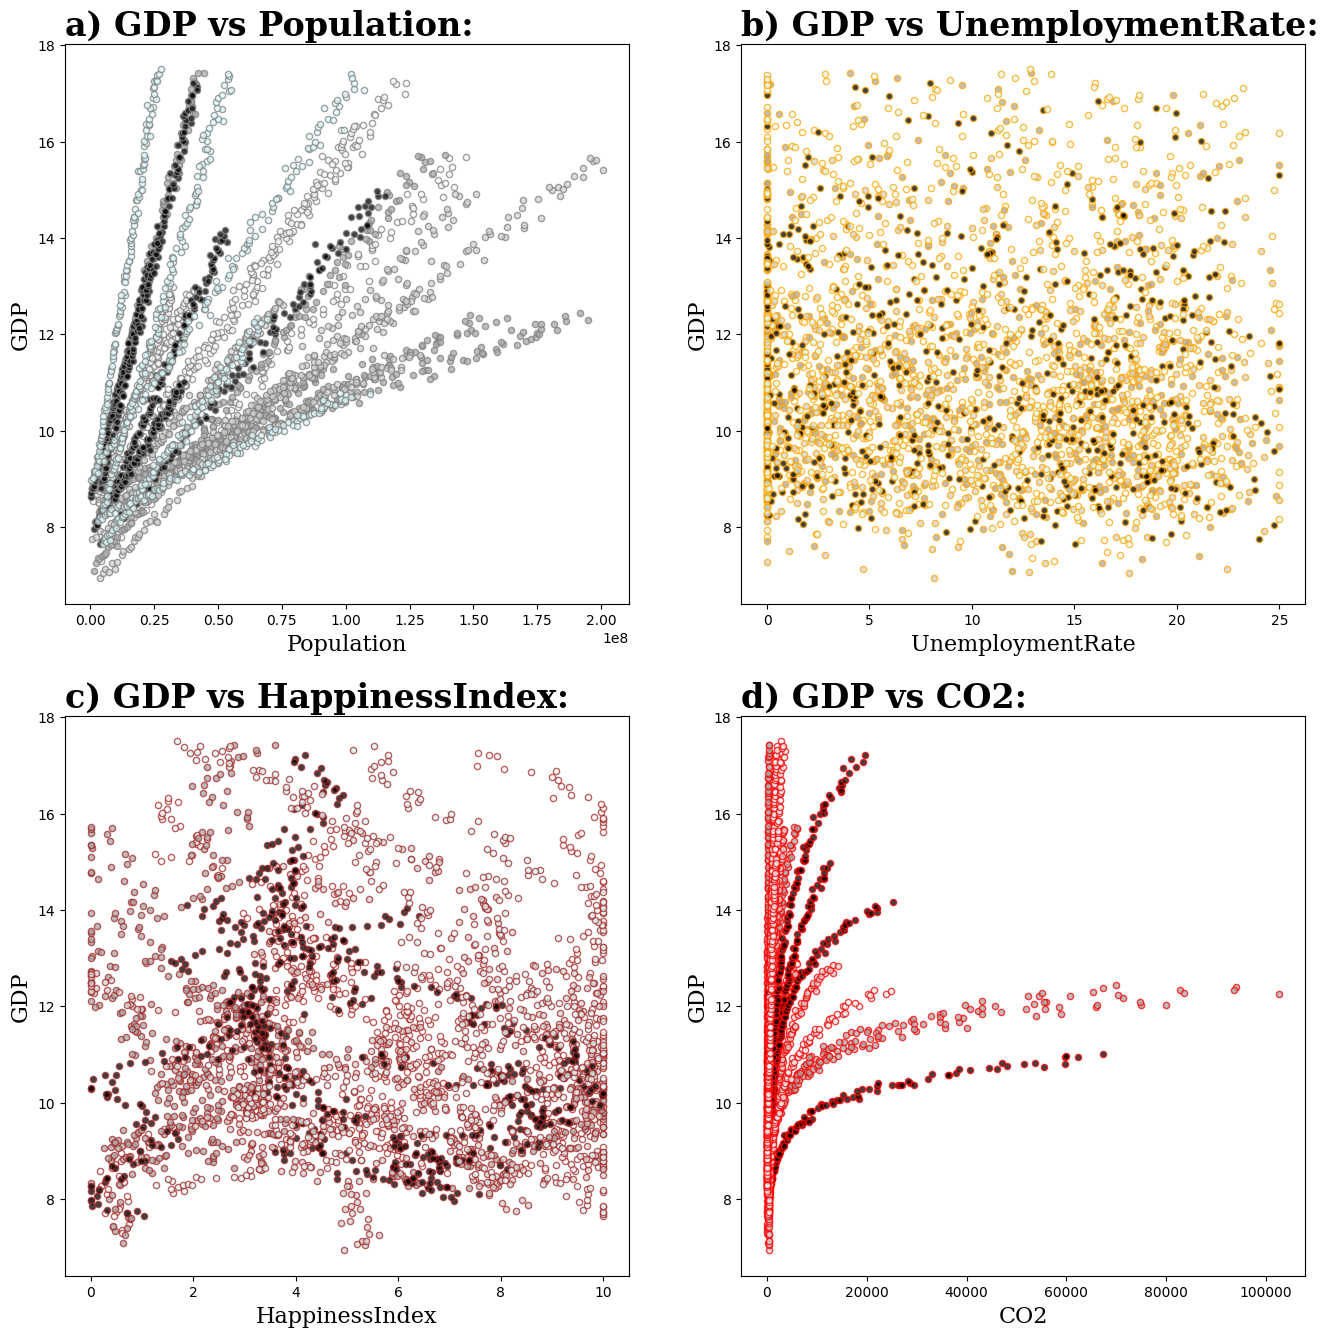

In [11]:
fig, axes = plt.subplots(2,2, figsize=(8*2,8*2))
plotted = AxesComposer(axes, plots=plots)
ax = plotted.draw()

### Store, Load and Draw the Created AxesComposer

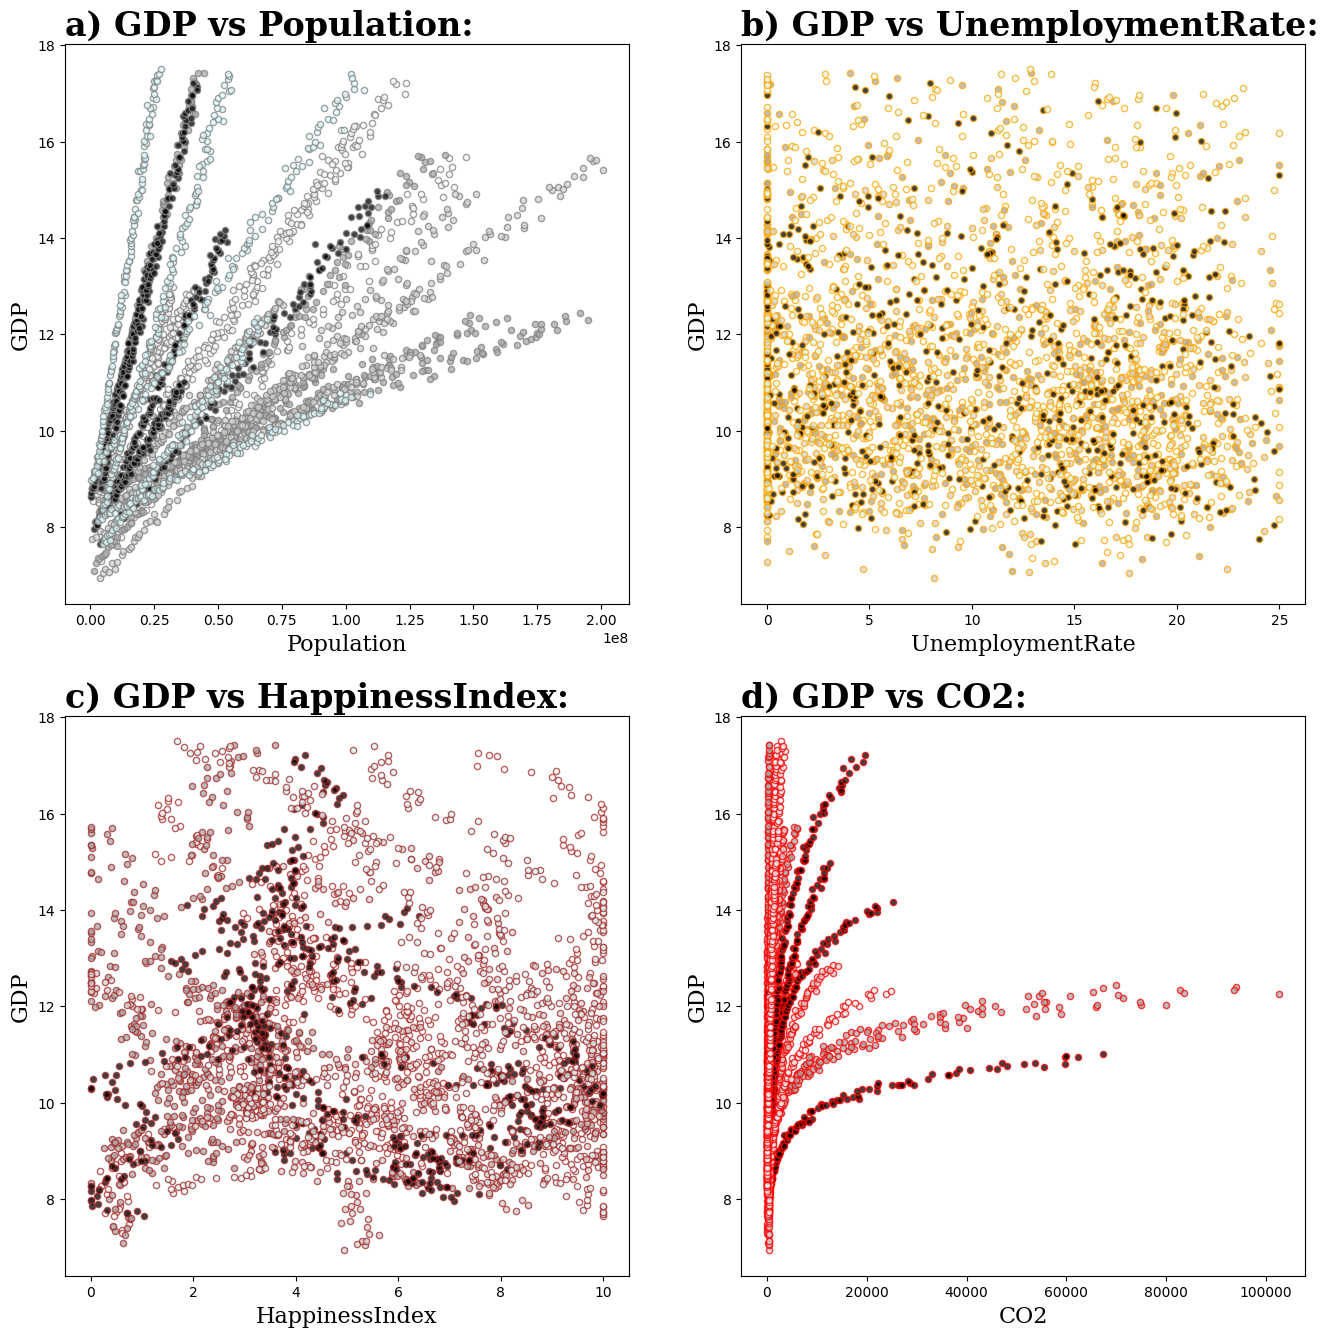

In [12]:
plotted.save_composer(".plot_params/composed_plot.json")
plotted = AxesComposer.from_json(".plot_params/composed_plot.json")
axes = plotted.draw()

## Individual PlotComposers in AxesComposer can be stored, loaded, and drawn independently

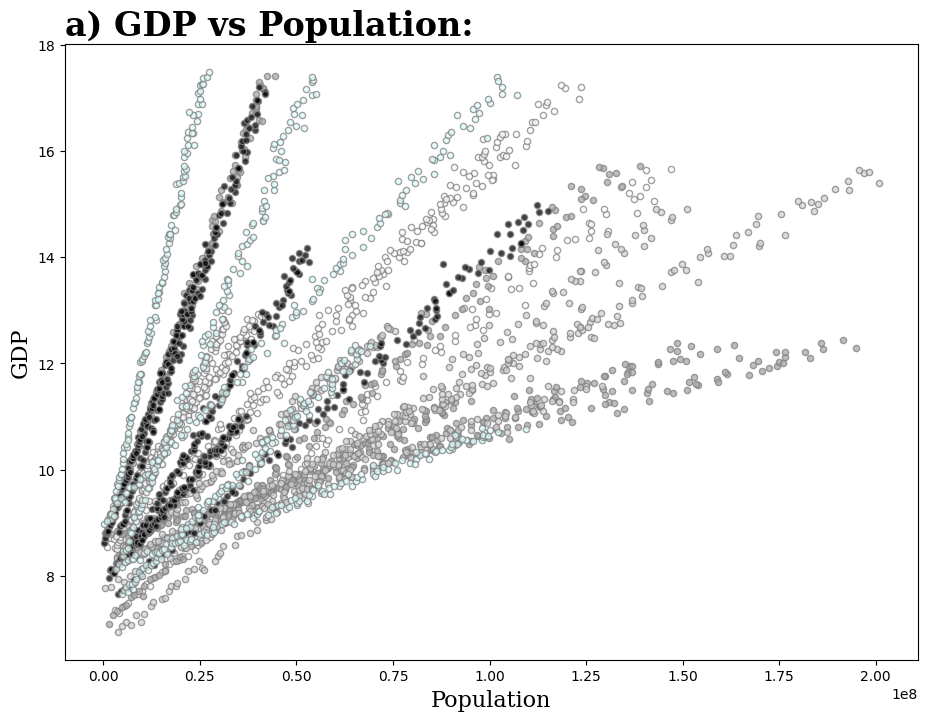

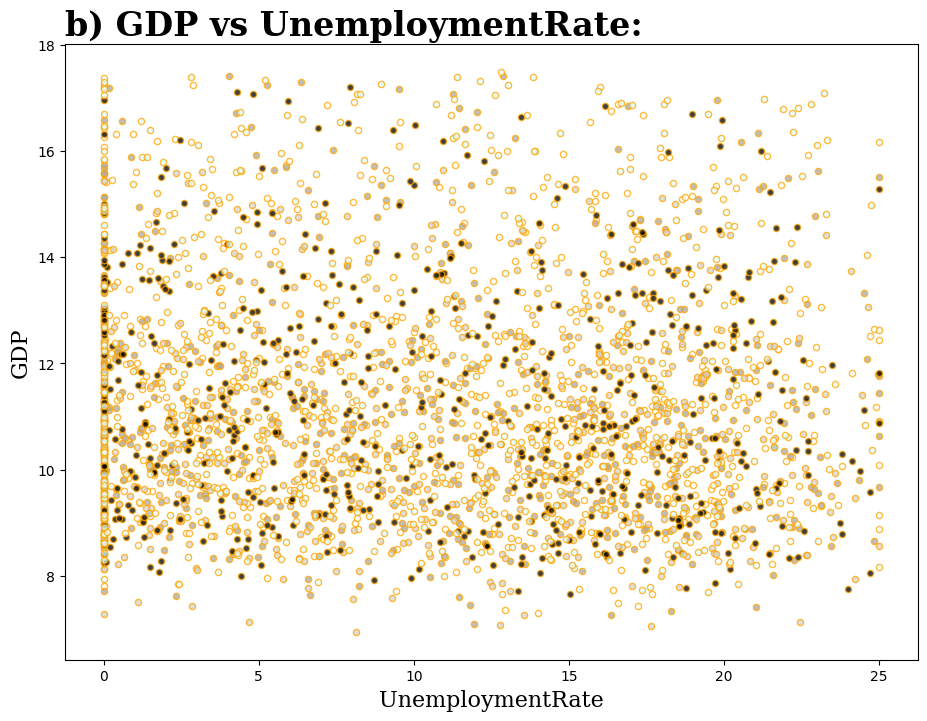

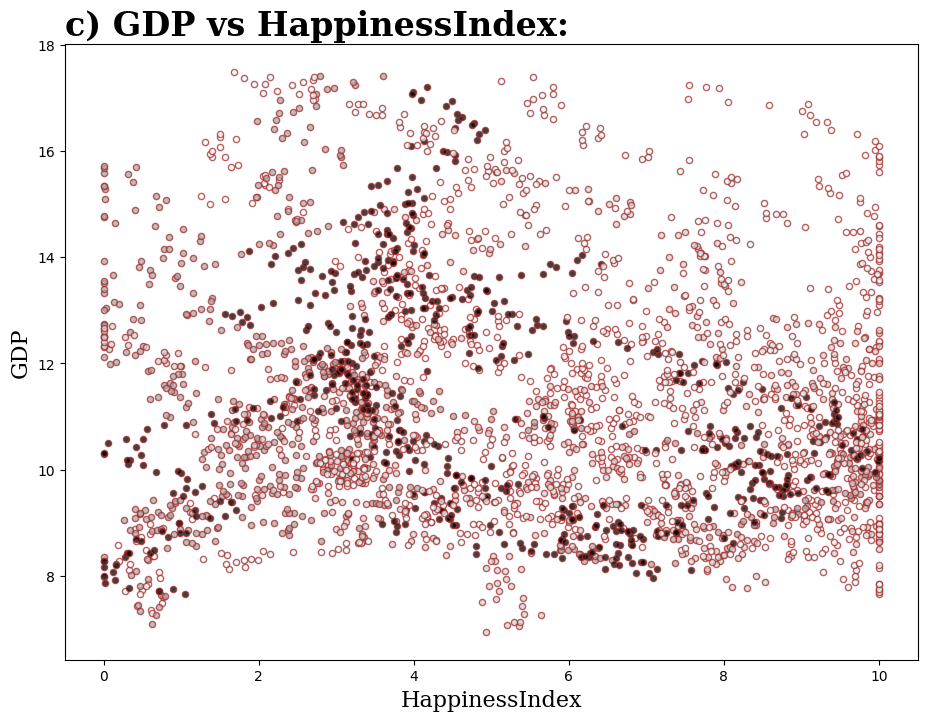

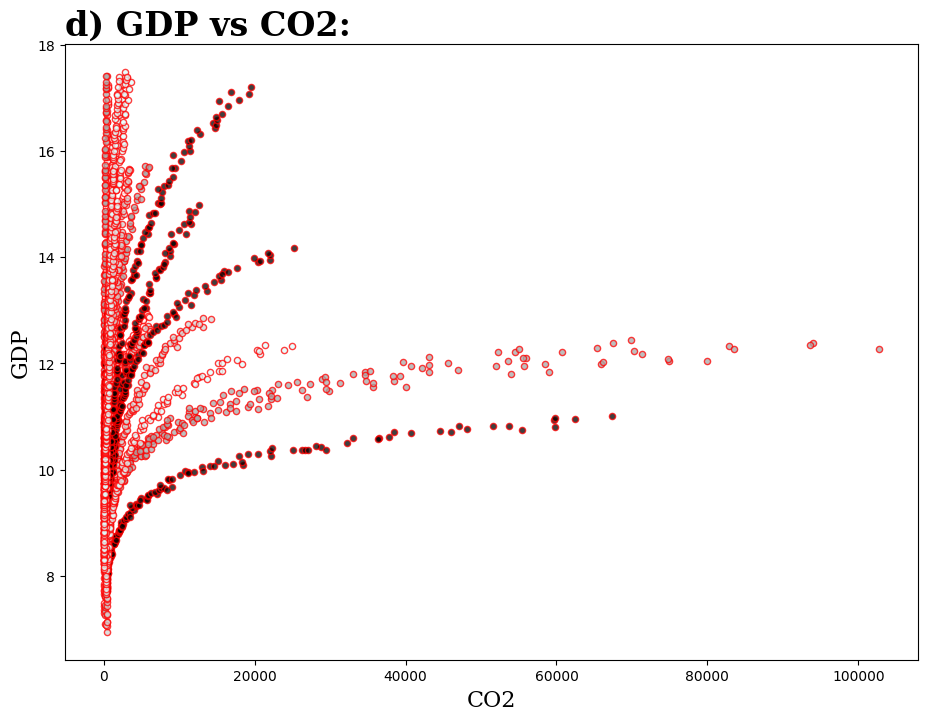

In [13]:
for plot in plotted.plots:
    plot.save_composer(".plot_params/composed_plot.json")
    plot = PlotComposer.from_json(".plot_params/composed_plot.json").set_figsize((11,8))
    plot.draw()

***